In [ ]:
# Install Required Libraries
#!pip install wordcloud scikit-learn datasets matplotlib seaborn tqdm pandas


# Suppress warnings

In [ ]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"



# Import Required Libraries

In [ ]:
import torch
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Load Dataset

In [ ]:
df = pd.read_csv("train.csv")

# Function to clean text data

In [ ]:
def clean_text(text):
    text = text.lower().strip()  # Convert to lowercase and remove leading/trailing spaces
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

df["clean_text"] = df["text"].apply(clean_text)



# Plot Class Distribution

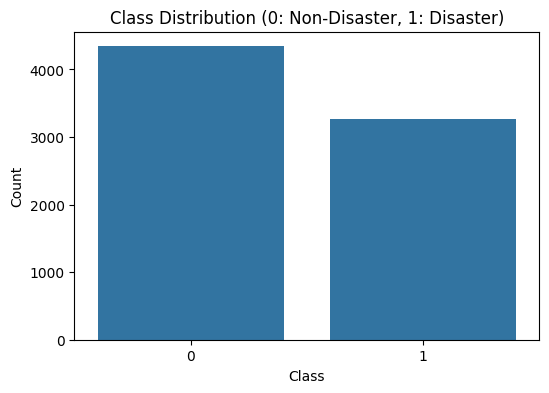

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["target"])
plt.title("Class Distribution (0: Non-Disaster, 1: Disaster)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Generate Word Clouds

In [ ]:
def generate_wordcloud(data, title):
    """Generates and displays a word cloud for a given text dataset."""
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(" ".join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds for disaster and non-disaster tweets

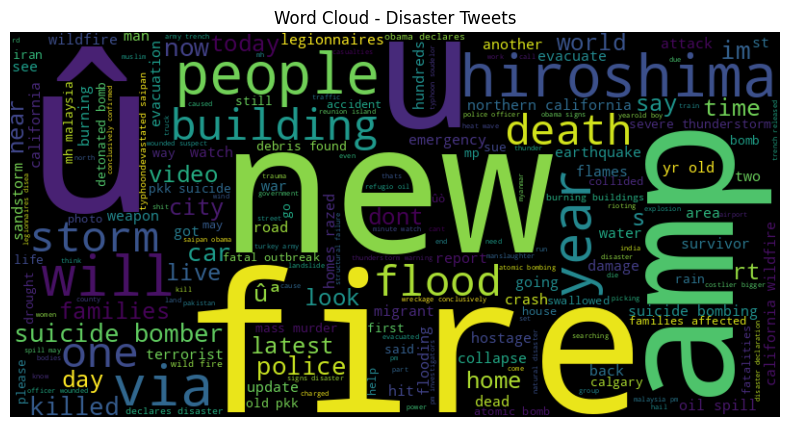

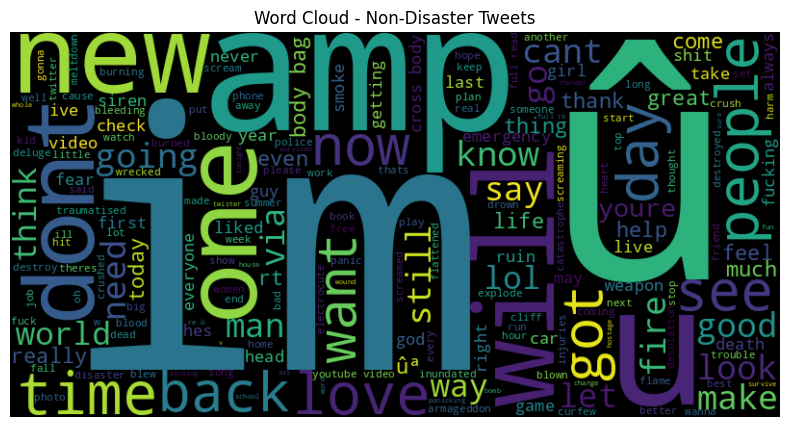

In [ ]:
generate_wordcloud(df[df["target"] == 1]["clean_text"], "Word Cloud - Disaster Tweets")
generate_wordcloud(df[df["target"] == 0]["clean_text"], "Word Cloud - Non-Disaster Tweets")

# Tweet Length Distribution

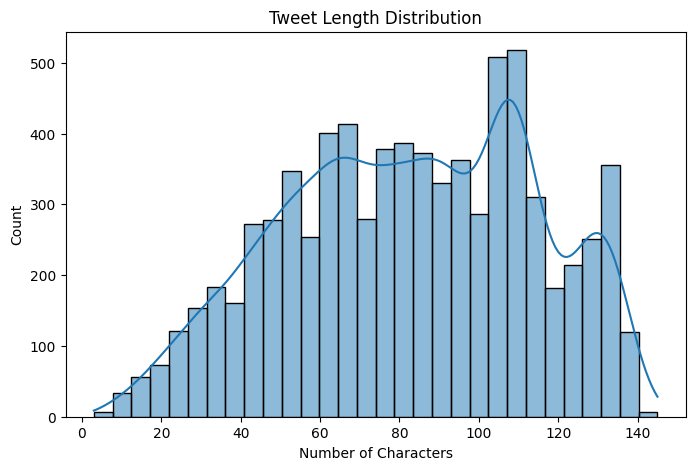

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["clean_text"].apply(len), bins=30, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.show()


# Split dataset into training and validation sets

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text"], df["target"], test_size=0.2, random_state=42
)

# Convert text data into numerical features using TF-IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)  # Limit vocabulary size to 5000 words
train_tfidf = tfidf.fit_transform(train_texts)
val_tfidf = tfidf.transform(val_texts)


# Apply PCA for dimensionality reduction

In [ ]:
pca = PCA(n_components=100)  # Reduce to 100 dimensions for efficiency
train_pca = pca.fit_transform(train_tfidf.toarray())
val_pca = pca.transform(val_tfidf.toarray())

# Define and Train Logistic Regression Model

In [ ]:
model = LogisticRegression()
model.fit(train_pca, train_labels)


LogisticRegression()

# Make Predictions on Validation Set

In [ ]:
predictions = model.predict(val_pca)


array([0, 0, 1, ..., 1, 1, 0])

In [ ]:
df_test = pd.read_csv("test.csv")

In [ ]:
test_tfidf = tfidf.transform(df_test['text'])
test_pca = pca.transform(test_tfidf.toarray())
preds = model.predict(test_pca)
preds.size

3263

In [ ]:
submission = df_test['id']
sub = submission.to_frame()
sub['target'] = preds
sub

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,1


In [ ]:
from google.colab import files
sub.to_csv('submission.csv', index=False)
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate Model Performance

In [ ]:
accuracy = accuracy_score(val_labels, predictions)
f1 = f1_score(val_labels, predictions)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Validation Accuracy: 0.7623
Validation F1 Score: 0.6874
